In [170]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from itertools import repeat
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [3]:
def conv(s):
    if s == '':
        return np.nan
    return float(s.replace(',', '.'))

columns_to_conv = ['Нефть, т', 'Конденсат, т', 'Приемистость, м3/сут', 'Обводненность (вес), %', 'Нефть, м3', 'Жидкость, м3', \
                    'Дебит конденсата', 'Добыча растворенного газа, м3', 'Дебит попутного газа, м3/сут']
convertors = dict(zip(columns_to_conv, repeat(conv.__call__, len(columns_to_conv))))

def conv_date(x):
    if x.day != 1:
        return (x + pd.offsets.MonthBegin(1))
    else:
        return x

In [4]:
df_train = pd.read_csv('init/1/train_1.8.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)
df_test = pd.read_csv('init/1/test_1.9.csv', header = 0 ,encoding = 'cp1251', parse_dates = ['Дата'], converters= convertors)

df_coord_train = pd.read_csv('init/1/coords_train_1.1.csv', header = 0,encoding = 'cp1251')
df_coord_test = pd.read_csv('init/1/coords_test_1.1.csv', header = 0,encoding = 'cp1251')

df_frac_train = pd.read_csv('init/1/frac_train_1.csv', header = 0,encoding = 'cp1251')
df_frac_test = pd.read_csv('init/1/frac_test_1.csv', header = 0,encoding = 'cp1251')

df_gdis_train = pd.read_csv('init/1/gdis_train1.2.csv', header = 0,encoding = 'cp1251')
df_gdis_test = pd.read_csv('init/1/gdis_test1.2.csv', header = 0,encoding = 'cp1251')

In [10]:
df_coord_train['x'] = df_coord_train['ПЛАСТ_X'].astype(dtype='int32')
df_coord_train['y'] = df_coord_train['ПЛАСТ_Y'].astype(dtype='int32')
df_coord_train['x'] = df_coord_train['x'] - df_coord_train['x'].mean()
df_coord_train['y'] = df_coord_train['y'] - df_coord_train['y'].mean()

df_coord_train['x_head'] = df_coord_train['УСТЬЕ_X'].astype(dtype='int32')
df_coord_train['y_head'] = df_coord_train['УСТЬЕ_Y'].astype(dtype='int32')
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()
df_coord_train['x_head'] = df_coord_train['x_head'] - df_coord_train['x_head'].mean()

<IPython.core.display.Javascript object>


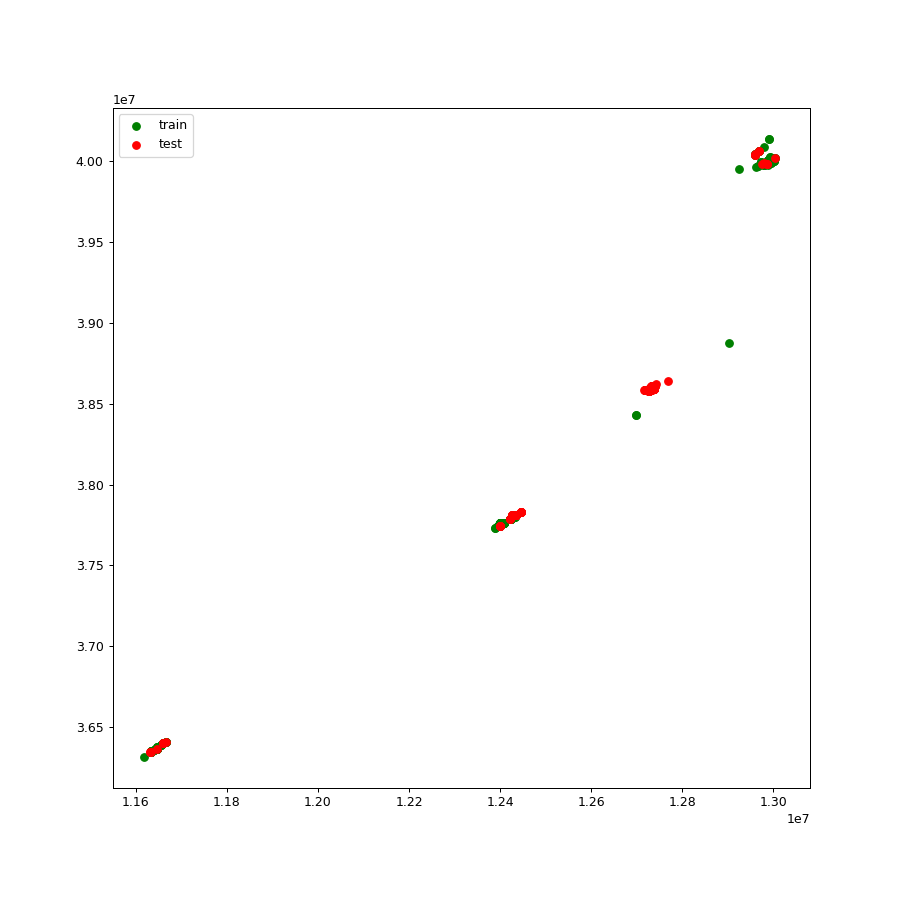

In [12]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.scatter(df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_train.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'g', label='train')
plt.scatter(df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_X'], 
            df_coord_test.drop_duplicates('well_hash', 'first')['ПЛАСТ_Y'], color = 'r', label='test')
plt.legend()

In [13]:
w_coord_train = df_coord_train['well_hash'].unique()
w_coord_test = df_coord_test['well_hash'].unique()
w_train = df_train['Скважина'].unique()
w_test = df_test['Скважина'].unique()
w_frac_train = df_frac_train['Скважина'].unique()
w_frac_test = df_frac_test['Скважина'].unique()
w_gdis_train = df_gdis_train['Скважина'].unique()
w_gdis_test = df_gdis_test['Скважина'].unique()

In [14]:
print('# of wells in train: ', len(w_train))
print('# of wells in coord train: ', len(w_coord_train))
print('# of wells intersect train and coord train: ', len(list(set(w_train) & set(w_coord_train))))
print('# of wells in frac train: ', len(w_frac_train))
print('# of wells in gdis train: ', len(w_gdis_train))

# of wells in train:  563
# of wells in coord train:  234
# of wells intersect train and coord train:  233
# of wells in frac train:  490
# of wells in gdis train:  388


In [15]:
print('# of wells in test: ', len(w_test))
print('# of wells in coord test: ', len(w_coord_test))
print('# of wells in frac test: ', len(w_frac_test))
print('# of wells in gdis test: ', len(w_gdis_test))

# of wells in test:  266
# of wells in coord test:  137
# of wells in frac test:  193
# of wells in gdis test:  106


In [17]:
df_train['oil_rate'] = df_train['Нефть, м3']/(df_train['Время работы, ч']/24)

df_train['liq_rate'] = df_train['Жидкость, м3']/(df_train['Время работы, ч']/24)

df_train.loc[df_train['liq_rate'].isnull(), 'liq_rate'] = df_train[df_train['liq_rate'].isnull()]['Дебит жидкости']

df_train.loc[df_train['oil_rate'].isnull(), 'oil_rate'] = df_train[df_train['oil_rate'].isnull()]['liq_rate'] \
                                                            *(1-df_train[df_train['oil_rate'].isnull()]['Обводненность']/100)

df_train.loc[:, 'Дата'] = df_train['Дата'].apply(conv_date)

df_train['wct'] = 1 - df_train['Нефть, м3']/df_train['Жидкость, м3']
df_train.loc[df_train['wct'].isnull(), 'wct'] = df_train.loc[df_train['wct'].isnull(), 'Обводненность']/100

df_train['gas_rate'] = df_train['Попутный газ, м3']/(df_train['Время работы, ч']/24)
df_train.loc[df_train['gas_rate'].isnull(), 'gas_rate'] = df_train[df_train['gas_rate'].isnull()]['Газовый фактор']* \
                                                           df_train[df_train['gas_rate'].isnull()]['oil_rate'] 


df_train['gf'] = df_train['Попутный газ, м3']/df_train['Нефть, т']
df_train.loc[df_train['gf'].isnull(), 'gf'] = df_train[df_train['gf'].isnull()]['Газовый фактор']

In [55]:
#df_train['gf_diff'] = df_train['Попутный газ, м3']/df_train['Нефть, т'] - df_train['Газовый фактор']

In [121]:
cols_of_interest = ['Скважина', 'Дата', 'liq_rate', 'oil_rate', 'wct', 'gas_rate', 'gf']
#df_train[['Скважина', 'Дата', 'liq_rate', 'oil_rate', 'wct', 'gas_rate', 'gf','Жидкость, м3', 'Нефть, м3', 'Время работы, ч', 'Дебит жидкости', 'Обводненность']]

,Скважина,Дата,liq_rate,oil_rate,wct,gas_rate,gf,"Жидкость, м3","Нефть, м3","Время работы, ч",Дебит жидкости,Обводненность
0,53514b4c4150ad897d82dd7d42cfc1a5,2012-04-01,75.083322,25.528505,0.659998,799.574751,36.000718,941.67,320.17,301.0,NaN,NaN
1,53514b4c4150ad897d82dd7d42cfc1a5,2012-05-01,62.666667,41.177667,0.342910,1289.666667,35.999405,1880.00,1235.33,720.0,76.00,66.0
2,53514b4c4150ad897d82dd7d42cfc1a5,2012-06-01,56.548387,38.813548,0.313622,1215.645161,36.000191,1753.00,1203.22,744.0,63.00,36.0
3,53514b4c4150ad897d82dd7d42cfc1a5,2012-07-01,46.774194,33.405484,0.285814,1046.258065,35.999778,1450.00,1035.57,744.0,53.00,30.0
4,53514b4c4150ad897d82dd7d42cfc1a5,2012-08-01,42.000000,29.184667,0.305127,914.066667,36.000105,1260.00,875.54,720.0,47.00,25.0
5,53514b4c4150ad897d82dd7d42cfc1a5,2012-09-01,36.935484,24.171613,0.345572,757.064516,36.000368,1145.00,749.32,744.0,42.00,29.0
6,fe017a547ac58cc7366a60cc6bcd3915,2013-09-01,19.610000,4.902500,0.750000,176.490000,36.000000,NaN,NaN,NaN,19.61,75.0
7,fe017a547ac58cc7366a60cc6bcd3915,2013-10-01,109.000000,31.610000,0.710000,1137.960000,36.000000,NaN,NaN,NaN,109.00,71.0
8,fe017a547ac58cc7366a60cc6bcd3915,2013-11-01,97.000000,65.960000,0.320000,2374.560000,36.000000,NaN,NaN,NaN,97.00,32.0
9,fe017a547ac58cc7366a60cc6bcd3915,2013-12-01,80.000000,53.600000,0.330000,1929.600000,36.000000,NaN,NaN,NaN,80.00,33.0


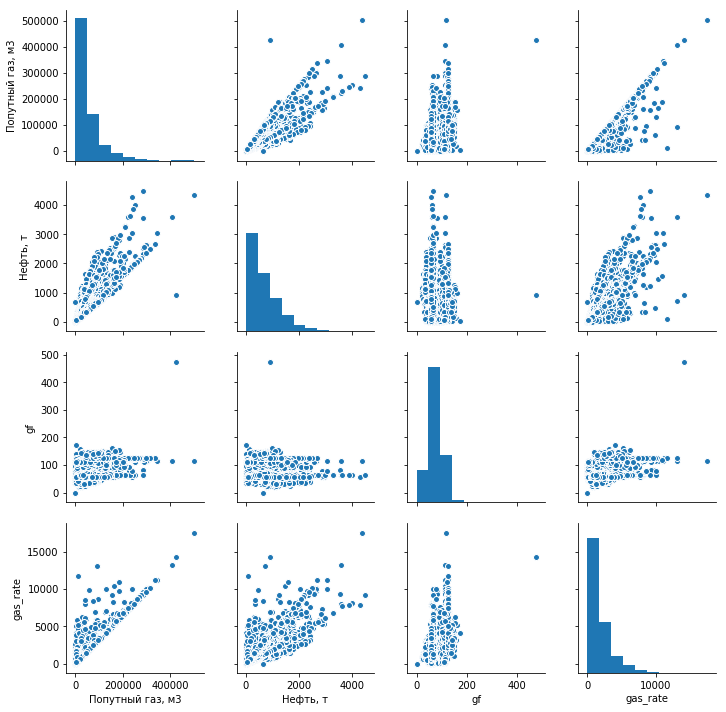

In [167]:
sns.pairplot(data = df_train[['Попутный газ, м3', 'Нефть, т', 'gf', 'gas_rate']].dropna())

In [122]:
df_train_temp = df_train[cols_of_interest]
#df_train_temp.loc[:,'Дата'] = df_train_temp['Дата'].asfreq('M')


wells_start = df_train_temp[df_train_temp['liq_rate'].isnull()]['Скважина'].unique().tolist()

AttributeError_wells = []
ValueError_wells = []
for well in wells_start:
#well = 'a2d46cb2c0cce62767b4cd7dacc28d1e'
    df_well_train = df_train_temp[df_train_temp['Скважина'] == well].set_index('Дата')
    #df_well_train.index.rename('Дата', inplace=True)
    start_index = df_well_train['liq_rate'].first_valid_index()
    try:
        m_shift = start_index.to_period('M') - df_well_train.first_valid_index().to_period('M')
        last_index = pd.Timestamp(df_well_train.last_valid_index(), freq = 'MS') + m_shift
    
        df_train_temp.loc[df_train_temp['Скважина'] == well, :] = df_well_train.reindex(index = pd.date_range(start_index, last_index, freq = 'MS')). \
                                        fillna(method='ffill').reset_index().set_index('Скважина').reset_index().values
    except AttributeError:
        AttributeError_wells.append(well)
    except ValueError:
        ValueError_wells.append(well)
    #df_train_temp_b.loc[df_train_temp['Скважина'] == well]

In [136]:
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(ValueError_wells)]
df_train_temp = df_train_temp[~df_train_temp['Скважина'].isin(AttributeError_wells)]

In [149]:
df_train_temp_b = df_train_temp.copy()
df_train_temp_b['month'] = 0
short_wells = []
for well in df_train_temp_b['Скважина'].unique().tolist():
    num_month = df_train_temp_b.loc[df_train_temp_b['Скважина'] == well].shape[0]
    if num_month != 6:
        short_wells.append(well)
    df_train_temp_b.loc[df_train_temp_b['Скважина'] == well, 'month'] = list(range(num_month))
        

In [151]:
df_train_temp_b = df_train_temp_b[~df_train_temp_b['Скважина'].isin(short_wells)]

In [180]:
df_liq_train = df_train_temp_b[['Скважина','month', 'liq_rate']].set_index(['Скважина', 'month']).unstack(0).fillna(0)
df_liq_train.columns = df_liq_train.columns.droplevel(0)

In [185]:
df_liq_train.loc[:, (df_liq_train.iloc[0,:] - df_liq_train.iloc[1,:]) > 0]

Скважина,005642f48d3e86d871bb701bac2ba042,02dba139f57f4aa50c3fbf56f586551f,04154a658a396d1c18331ebf0330744f,047a7a651d481e1c43b691c9e7dc07c9,04d7884a9f7019671285b87ca468d0f1,053c7b37c95c4617f331791134227db7,0556368a803a0c64972646d4bfaecd86,0629ab7d6c84f651f73ec122c9bb4237,065b308066161ae96d2f1f8bca1afe0e,06ea4252d9311316b20a10f3f8266b26,...,fa2ab12ddbcedd3d2330c50d88d04d17,fa5687dcaa35024568981760194e11a3,fb012029fe2af5b8e9a7c49f0f06d81f,fb61ed2104e11829c6f3e86eeb46dc0d,fb8de1efd55f5f174f7cd9125aaf2736,fc330f0bffba3e7b5a612199a98a1ce0,fc73d9d98621e750b923524cfbc4d09b,fd9cd51e3c889beb7b75704c19861bff,fe6637ba6939eaca6a8da0bf58b0d1d7,ff3a625575f0eb398958d89c9f3dba5a
month,,,,,,,,,,,,,,,,,,,,,
0,29.777778,24.642857,18.000000,11.212214,90.038710,58.666667,84.576923,4.800000,76.0,26.966667,...,133.315656,73.148148,8.434783,90.0,96.562500,56.422000,72.898889,47.300000,3.343284,126.0
1,6.290323,24.612903,11.516129,9.709677,71.161290,46.354839,72.935484,4.677419,50.0,26.161290,...,81.103000,56.129032,6.066667,78.0,83.580645,53.848000,58.624483,40.800000,0.733333,79.0
2,5.366667,14.129032,6.166667,1.833333,98.258065,35.400000,58.233333,4.548387,28.0,66.461538,...,47.356452,49.900000,6.935484,70.0,77.400000,53.505484,48.225806,16.032258,0.741935,75.0
3,5.500000,12.250000,3.548387,1.870968,106.142857,29.838710,52.096774,4.548387,25.0,68.966667,...,36.846774,49.419355,6.200000,60.0,71.870968,50.972903,62.239667,11.838710,0.935484,69.0
4,9.733333,10.451613,3.366667,1.870968,101.354839,27.516129,48.483871,4.548387,28.0,52.911323,...,32.521433,50.516129,7.032258,53.0,68.333333,50.972903,40.931935,11.900000,0.857143,62.0
5,47.129032,10.451613,3.419355,1.870968,99.300000,25.178571,50.333333,4.548387,20.0,39.967742,...,32.521433,50.516129,7.032258,57.0,66.903226,50.972903,33.318667,11.900000,0.967742,61.0


In [182]:
(df_liq_train.iloc[0,:] - df_liq_train.iloc[1,:]) < 0

Скважина
005642f48d3e86d871bb701bac2ba042    False
02384c4d1324238fb99fcf66c88fbdad     True
02bd0350b7f0cef7af7ca50801d89810     True
02dba139f57f4aa50c3fbf56f586551f    False
031f7cf95ada8d6e49ad6bd96c886d9c     True
038753062b1b3941bbce024a2af27e18     True
03d2a660f0b807a6a8cb3fc92575e13b     True
04154a658a396d1c18331ebf0330744f    False
046568c4bd1c6343c5f932ef6a21b112     True
047a7a651d481e1c43b691c9e7dc07c9    False
04d7884a9f7019671285b87ca468d0f1    False
053c7b37c95c4617f331791134227db7    False
0556368a803a0c64972646d4bfaecd86    False
05ac8fa0edaeedff9ad4b752f9c9383b     True
061047df78f8b8cca17f37f266c9f527     True
0629ab7d6c84f651f73ec122c9bb4237    False
065b308066161ae96d2f1f8bca1afe0e    False
06ea4252d9311316b20a10f3f8266b26    False
076ba09a8e0c70e1df2c06f45d653b31     True
07759c3ef2b803a9223d72d37908cf41    False
08a150adf24e74844be252fdd26c407c    False
08ae5c9355f8f4d8fe6fef9a62f69703    False
097278c74db2f57facb9a33a3857d995    False
09dfc186d24aab3aa8fc541f3

In [189]:
#df_liq_train_norm = df_liq_train.copy()
liq_scaler = MinMaxScaler()
df_liq_train_norm = pd.DataFrame(liq_scaler.fit(df_liq_train.values).transform(df_liq_train.values), 
                                 index = df_liq_train.index, columns = df_liq_train.columns)

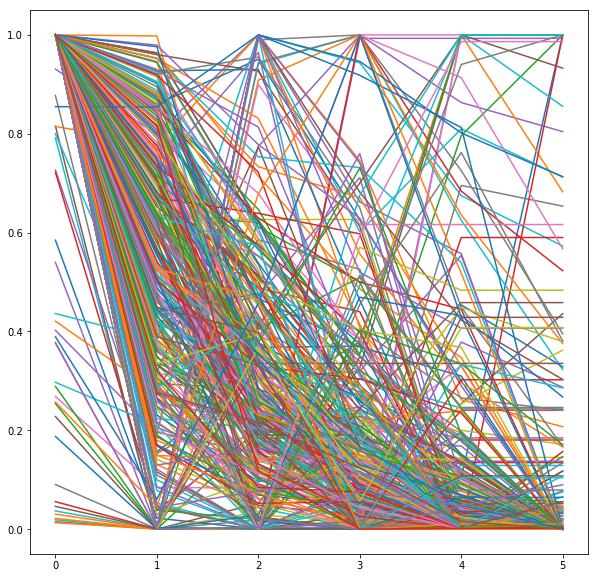

In [190]:
plt.figure(figsize=(10,10))
plt.plot(df_liq_train_norm.loc[:, (df_liq_train_norm.iloc[0,:] - df_liq_train_norm.iloc[1,:]) > 0])